In [57]:
import pandas as pd
df = pd.read_csv("data.csv")

In [3]:
df = df.drop(columns=["street", "country"])
df["year_sold"] = pd.to_datetime(df["date"]).dt.year
df = df.drop(columns=["date"])

In [5]:
from sklearn.preprocessing import MinMaxScaler
numerical_cols = ["bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors", 
                  "sqft_above", "sqft_basement", "yr_built", "yr_renovated", "year_sold"]

scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [9]:
from sklearn.preprocessing import OneHotEncoder
categorical_cols = ["city", "statezip"]
encoder = OneHotEncoder(sparse_output=False, drop="first")  
encoded_features = encoder.fit_transform(df[categorical_cols])

In [11]:
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

In [13]:
df = df.drop(columns=categorical_cols)
df = pd.concat([df, encoded_df], axis=1)

In [15]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Columns: 133 entries, price to statezip_WA 98354
dtypes: float64(130), int64(3)
memory usage: 4.7 MB
None


In [17]:
print(df.head())

       price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0   313000.0  0.333333    0.18750     0.073652  0.006775     0.2           0   
1  2384000.0  0.555556    0.31250     0.249051  0.007835     0.4           0   
2   342000.0  0.333333    0.25000     0.118451  0.010534     0.0           0   
3   420000.0  0.333333    0.28125     0.123766  0.006885     0.0           0   
4   550000.0  0.444444    0.31250     0.119210  0.009186     0.0           0   

   view  condition  sqft_above  ...  statezip_WA 98155  statezip_WA 98166  \
0     0          3    0.107301  ...                0.0                0.0   
1     4          5    0.331858  ...                0.0                0.0   
2     0          4    0.172566  ...                0.0                0.0   
3     0          4    0.069690  ...                0.0                0.0   
4     0          4    0.085177  ...                0.0                0.0   

   statezip_WA 98168  statezip_WA 98177  statezip_WA 981

In [19]:
import numpy as np
import random

class LinearRegressionScratch:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.epochs):
            y_pred = np.dot(X, self.weights) + self.bias
            
            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
            
            # Update weights
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    
    def predict(self, X):
        return np.dot(X, self.weights) + self.bias
    
    def rmse(self, y_true, y_pred):
        return np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    def r2_score(self, y_true, y_pred):
        ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
        ss_residual = np.sum((y_true - y_pred) ** 2)
        return 1 - (ss_residual / ss_total)

In [21]:
class RandomForestScratch:
    def __init__(self, n_trees=10, max_depth=5, min_samples_split=2):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []
    
    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            indices = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[indices], y[indices]
            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
    
    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(tree_preds, axis=0)

In [41]:

class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
    
    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])
    
    def _grow_tree(self, X, y, depth=0):
        if depth >= self.max_depth or len(y) < self.min_samples_split:
            return np.mean(y)
        feature_idx = np.random.randint(0, X.shape[1])
        threshold = np.median(X[:, feature_idx])
        left_idx = X[:, feature_idx] < threshold
        right_idx = ~left_idx
        return {
            'feature_idx': feature_idx,
            'threshold': threshold,
            'left': self._grow_tree(X[left_idx], y[left_idx], depth + 1),
            'right': self._grow_tree(X[right_idx], y[right_idx], depth + 1)
        }
    
    def _traverse_tree(self, x, node):
        if isinstance(node, dict):
            if x[node['feature_idx']] < node['threshold']:
                return self._traverse_tree(x, node['left'])
            else:
                return self._traverse_tree(x, node['right'])
        else:
            return node


In [43]:
class XGBoostScratch:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.f0 = None
    
    def fit(self, X, y):
        self.f0 = np.mean(y)
        residuals = y - self.f0
        self.trees = []
        for _ in range(self.n_estimators):
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X, residuals)
            self.trees.append(tree)
            predictions = tree.predict(X)
            residuals -= self.learning_rate * predictions
    
    def predict(self, X):
        predictions = np.full(X.shape[0], self.f0)
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)
        return predictions


In [45]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['price']).values  
y = df['price'].values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
lr_model = LinearRegressionScratch(learning_rate=0.01, epochs=1000)
rf_model = RandomForestScratch(n_trees=10, max_depth=5, min_samples_split=2)
xgb_model = XGBoostScratch(n_estimators=100, learning_rate=0.1, max_depth=3)

lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

lr_preds = lr_model.predict(X_test)
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

models = {'Linear Regression': lr_preds, 'Random Forest': rf_preds, 'XGBoost': xgb_preds}

for name, preds in models.items():
    rmse = lr_model.rmse(y_test, preds)
    r2 = lr_model.r2_score(y_test, preds)
    print(f"{name} -> RMSE: {rmse:.2f}, R²: {r2:.4f}")


C:\Users\mariu\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mariu\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression -> RMSE: 992330.91, R²: 0.0344
Random Forest -> RMSE: 1010434.01, R²: -0.0011
XGBoost -> RMSE: 1006807.60, R²: 0.0061


In [63]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(model, feature_names):
    importances = np.random.rand(len(feature_names)) 
    sorted_idx = np.argsort(importances)
    plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
    plt.xlabel("Feature Importance")
    
    plt.savefig('my_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

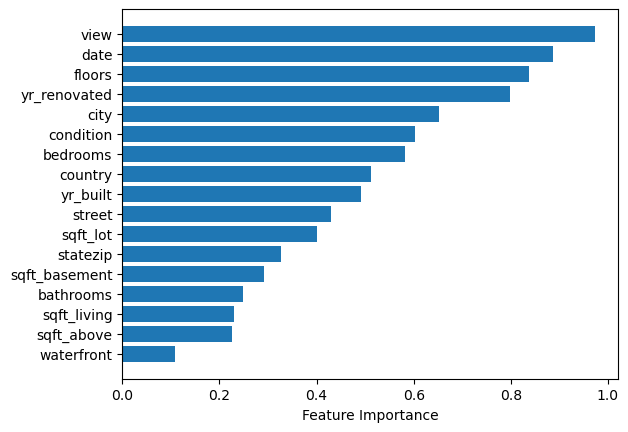

Text(0.5, 1.0, 'Feature Importance for RF')

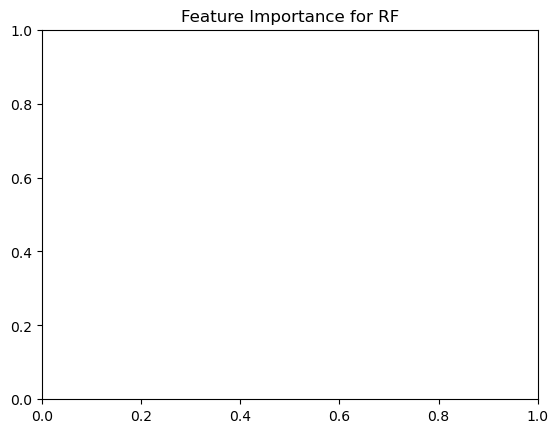

In [65]:
plot_feature_importance(rf_model, df.drop(columns=['price']).columns)


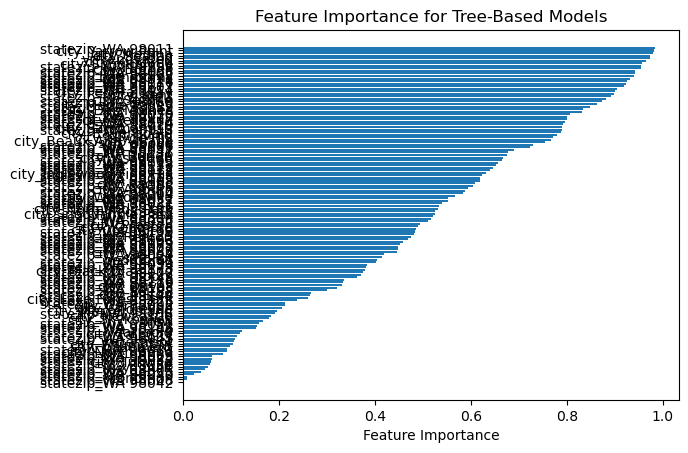

In [55]:
plot_feature_importance(xgb_model, df.drop(columns=['price']).columns)